Let's load the data and choose AP0

In [159]:

library(repr);
library(dplyr);
library(prophet);
library(plotly);
options(repr.plot.width=6.5, repr.plot.height=3)
options(digits=2)
source_file_dir='/Users/abertran/Documents/gitRepositories/TTL_prod_code/'

source(paste(source_file_dir,"source_common_files.R",sep=""))

source(paste(source_file_dir,"readDBSizeDatadB.R",sep=""))
source(paste(source_file_dir,"parameters_DBSize.R",sep=""))
source(paste(source_file_dir,"PlotFunctionsForJupyter.R",sep=""))

data = readDBSizeDatadB()
data$pod = toupper(data$pod)
str_pod="AP0";
metric_label="ASM_Used"

pod_data=data[which(data$pod==str_pod),]
TTL=(pod_data[dim(pod_data)[1],"total_db_size_in_tb"]-15)*0.97;

#Note that need to set an end time so that the values don't keep changing every day I run the analysis
pod_data=pod_data[which(pod_data$timestamp<as.POSIXct("2017-09-12", format="%Y-%m-%d",tz="UTC",origin="1970-01-01")),]

Plot the base data

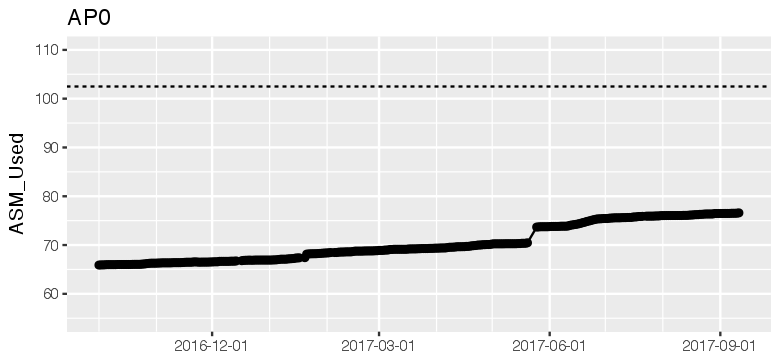

In [160]:
pod_dataDF=as.data.frame(pod_data$timestamp);
pod_dataDF$data=pod_data$used_db_space_in_tb;
colnames(pod_dataDF)=c('timestamp','data');
PlotJustTimeSeries(pod_dataDF,str_pod,metric_label,TTL,55,110);

Let's choose the timeseries until 2017/07/11 as our training data and from 2017/07/11 till 2017/09/11 as our test data. In practice we should also leave a timeframe for cross-validation - trying different parameters to see which one has the best fit but in this analyisis we are not aiming at choosing optimal parameters.

In [161]:
prophetDF=pod_dataDF
colnames(prophetDF)=c('ds','y')
end_training = as.POSIXct("2017-07-11", format="%Y-%m-%d",tz="UTC",origin="1970-01-01")

trainingDF=prophetDF[which(prophetDF$ds < end_training ), ]
testDF=prophetDF[which(prophetDF$ds >= end_training), ]

end_training_index=which(prophetDF$ds == end_training )-1
prophetDF[end_training_index,]

,ds,y
274,2017-07-10,76


If we run Prophet with default parameters for this data we get:

trying deprecated constructor; please alert package maintainer


Initial log joint probability = -2.10467
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Warning message:
“Removed 639 rows containing missing values (geom_hline).”

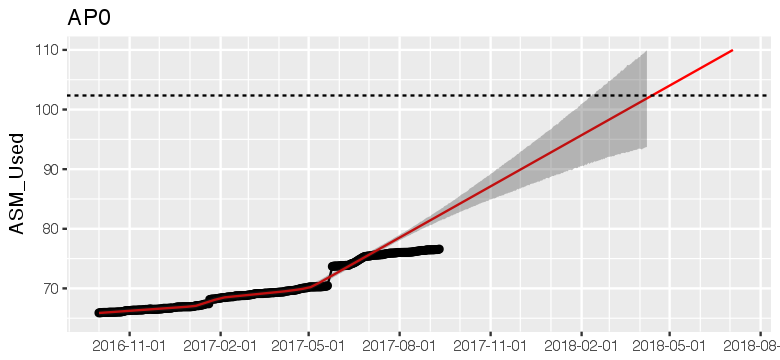

Warning message in testDF$y - forecast$yhat[(end_training_index + 1):(end_training_index + :
“longer object length is not a multiple of shorter object length”

[1] "MAPE for training set: 0.16"
[1] "MAPE for test set: 3.34"
[1] "Value at last timestamp: 76.59"
[1] "Forecast value at last timestamp: 82.36"
[1] "Upper bound on forecast value at last timestamp: 83.24"
[1] "Lower bound on forecast Value at last timestamp: 81.42"


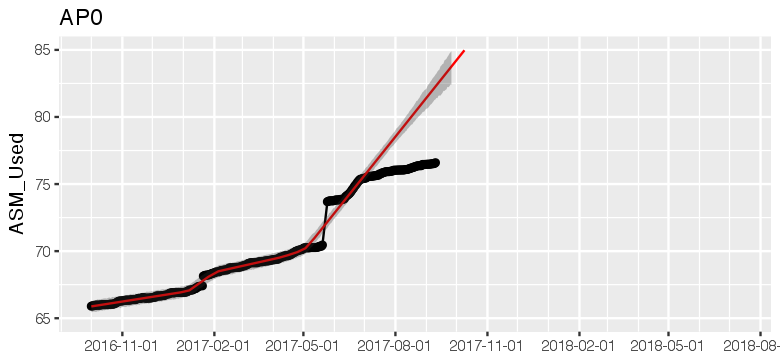

In [162]:

n_timeseries=dim(trainingDF)[1]
n_prediction=365
n_data=n_timeseries+n_prediction


m <- prophet(trainingDF,weekly.seasonality=FALSE,yearly.seasonality=FALSE);
future <- make_future_dataframe(m, periods = n_prediction);
forecast <- predict(m, future);

dFResults=as.data.frame(1:n_data);
forecast$timestamp=as.POSIXct(as.character(forecast$ds), format="%Y-%m-%d",tz="UTC",origin="1970-01-01");
dFResults$timestamp=forecast$timestamp#$timestamp=forecast$ds#c(forecast$ds,future_timestamps)
dFResults$data=c(prophetDF$y,rep(NA,(n_data-length(prophetDF$y))));
dFResults$dataForecast=forecast$yhat;
dFResults$dataForecastConfidenceUB=forecast$yhat_upper;
dFResults$dataForecastConfidenceLB=forecast$yhat_lower;

PlotTheData(dFResults=dFResults, str_pod=str_pod, metric_label=metric_label, TTL=TTL,ylimMin=65,ylimMax=110);
PlotTheData(dFResults=dFResults, str_pod=str_pod, metric_label=metric_label, TTL=TTL,ylimMin=65,ylimMax=85);

MAPE_training=mean(abs(trainingDF$y-forecast$yhat[1:end_training_index]))
MAPE_test=mean(abs(testDF$y-forecast$yhat[(end_training_index+1):(end_training_index+1+length(testDF$y))]))

print(paste('MAPE for training set: ',round(MAPE_training, 2),sep=""))
print(paste('MAPE for test set: ',round(MAPE_test, 2),sep=""))

max_timestamp=max(prophetDF$ds)

actual_value=prophetDF[which(prophetDF$ds==max_timestamp),"y"]
actual_value=format(round(actual_value, 2), nsmall = 2)
print(paste('Value at last timestamp:', actual_value))
forecast_value=forecast[which(difftime(forecast$ds,max_timestamp,units="days")==0),"yhat"]
forecast_value=format(round(forecast_value, 2), nsmall = 2)
forecast_ub=forecast[which(difftime(forecast$ds,max_timestamp,units="days")==0),"yhat_upper"]
forecast_ub=format(round(forecast_ub, 2), nsmall = 2)
forecast_lb=forecast[which(difftime(forecast$ds,max_timestamp,units="days")==0),"yhat_lower"]
forecast_lb=format(round(forecast_lb, 2), nsmall = 2)

print(paste('Forecast value at last timestamp:', forecast_value ))
print(paste('Upper bound on forecast value at last timestamp:', forecast_ub))
print(paste('Lower bound on forecast Value at last timestamp:', forecast_lb))


We can see that running Prophet with default parameters in this particular case causes us to predict a trend that is growing much faster than current actual. At the last timestamp, that is on 9/12/2017 the actual value is 76.6Tb while the forecasted value is 82.36Tb (~6Tb difference) while the upper bound of the forecast is 83.2Tb and lower bound 81.4Tb.

In this analysis we are using the last known timestamp to determine how useful the forecasting is because for PRA we are interested in the TTL and we should be able to predict with accuracy when we hit the TTL at least in the next 3 months and also in the next 6 months. The traditional MAPE numbers for the training set are 0.16Tb and 3.3Tb in this case. From now on, the numbers will be printed but not reported in the word paragraphs.

Now let's try increasing the number of change points and increasing flexibility by increasing the changepoint.prior.scale. As a second scenario we will feed Prophet the changepoints detected by PRA.

trying deprecated constructor; please alert package maintainer


Initial log joint probability = -2.10467
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Warning message:
“Removed 639 rows containing missing values (geom_hline).”

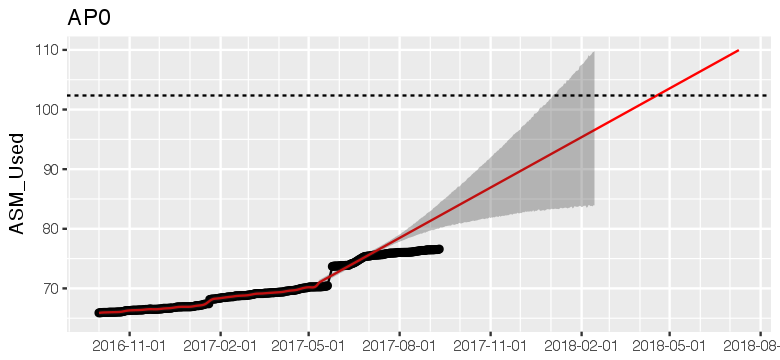

[1] "POSIXct" "POSIXt"

Warning message in testDF$y - forecast$yhat[(end_training_index + 1):(end_training_index + :
“longer object length is not a multiple of shorter object length”

[1] "MAPE for training set: 0.13"
[1] "MAPE for test set: 3.27"
[1] "Value at last timestamp: 76.59"
[1] "Forecast value at last timestamp: 82.24"
[1] "Upper bound on forecast value at last timestamp: 84.47"
[1] "Lower bound on forecast Value at last timestamp: 80.22"


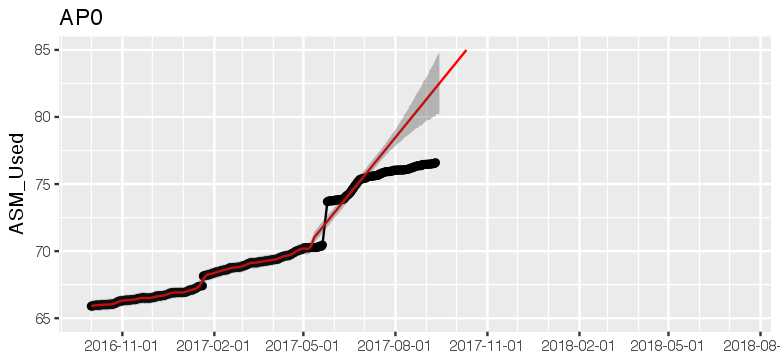

In [166]:
m <- prophet(trainingDF,weekly.seasonality=FALSE,yearly.seasonality=FALSE, n.changepoints=250,changepoint.prior.scale=10);
future <- make_future_dataframe(m, periods = n_prediction);
forecast <- predict(m, future);

dFResults=as.data.frame(1:n_data);
forecast$timestamp=as.POSIXct(as.character(forecast$ds), format="%Y-%m-%d",tz="UTC",origin="1970-01-01");
dFResults$timestamp=forecast$timestamp#$timestamp=forecast$ds#c(forecast$ds,future_timestamps)
dFResults$data=c(prophetDF$y,rep(NA,(n_data-length(prophetDF$y))));
dFResults$dataForecast=forecast$yhat;
dFResults$dataForecastConfidenceUB=forecast$yhat_upper;
dFResults$dataForecastConfidenceLB=forecast$yhat_lower;

PlotTheData(dFResults=dFResults, str_pod=str_pod, metric_label=metric_label, TTL=TTL,ylimMin=65,ylimMax=110);
PlotTheData(dFResults=dFResults, str_pod=str_pod, metric_label=metric_label, TTL=TTL,ylimMin=65,ylimMax=85);

max_timestamp=max(prophetDF$ds)
class(max_timestamp)

MAPE_training=mean(abs(trainingDF$y-forecast$yhat[1:end_training_index]))
MAPE_test=mean(abs(testDF$y-forecast$yhat[(end_training_index+1):(end_training_index+1+length(testDF$y))]))

print(paste('MAPE for training set: ',round(MAPE_training, 2),sep=""))
print(paste('MAPE for test set: ',round(MAPE_test, 2),sep=""))

actual_value=prophetDF[which(prophetDF$ds==max_timestamp),"y"]
actual_value=format(round(actual_value, 2), nsmall = 2)
print(paste('Value at last timestamp:', actual_value))
forecast_value=forecast[which(difftime(forecast$ds,max_timestamp,units="days")==0),"yhat"]
forecast_value=format(round(forecast_value, 2), nsmall = 2)
forecast_ub=forecast[which(difftime(forecast$ds,max_timestamp,units="days")==0),"yhat_upper"]
forecast_ub=format(round(forecast_ub, 2), nsmall = 2)
forecast_lb=forecast[which(difftime(forecast$ds,max_timestamp,units="days")==0),"yhat_lower"]
forecast_lb=format(round(forecast_lb, 2), nsmall = 2)
print(paste('Forecast value at last timestamp:', forecast_value ))
print(paste('Upper bound on forecast value at last timestamp:', forecast_ub))
print(paste('Lower bound on forecast Value at last timestamp:', forecast_lb))

We can see now that the uncertainty interval is wider and that the lower bound is now closer to our actual value.  At the last timestamp, that is on 9/12/2017 the actual value is 76.6 while the forecasted value is 82.33 (5.7Tb difference) while the upper bound of the forecast is 84.5 and lower bound 80.3 (3.7Tb difference).

Now let's try feeding it actual change points from PRA.

trying deprecated constructor; please alert package maintainer


Initial log joint probability = -2.10467
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Warning message:
“Removed 639 rows containing missing values (geom_hline).”

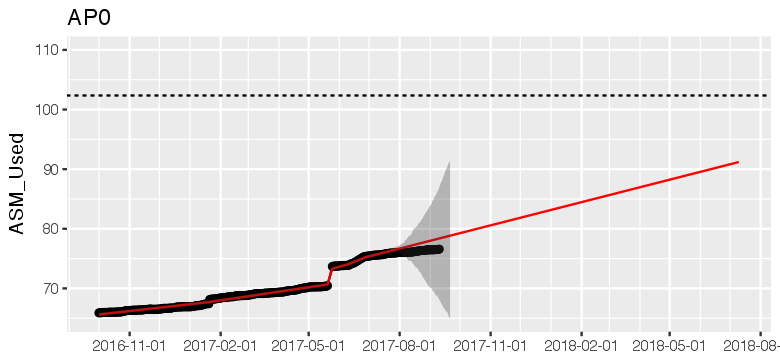

[1] "POSIXct" "POSIXt"

[1] "MAPE for training set: 0.13"
[1] "MAPE for test set: 3.27"
[1] "Value at last timestamp: 76.59"
[1] "Forecast value at last timestamp: 78.42"
[1] "Upper bound on forecast value at last timestamp: 87.38"
[1] "Lower bound on forecast Value at last timestamp: 67.86"


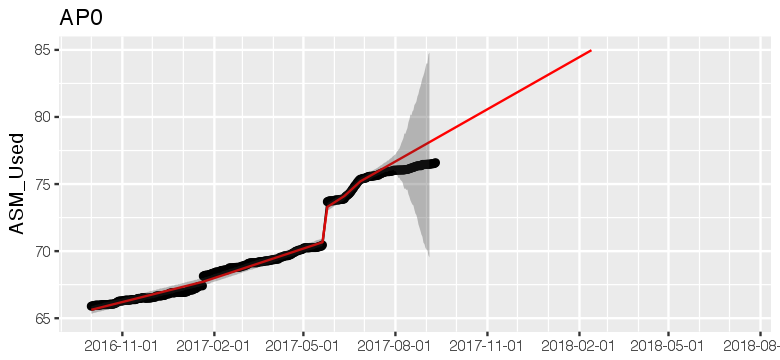

In [167]:
changepoints_from_pra=c("2017-01-21","2017-05-20","2017-05-25","2017-06-11","2017-06-27")
changepoints_from_pra=as.Date(changepoints_from_pra,format="%Y-%m-%d")
m <- prophet(trainingDF,weekly.seasonality=FALSE,yearly.seasonality=FALSE, changepoints=changepoints_from_pra)
future <- make_future_dataframe(m, periods = n_prediction);
forecast <- predict(m, future);

dFResults=as.data.frame(1:n_data);
forecast$timestamp=as.POSIXct(as.character(forecast$ds), format="%Y-%m-%d",tz="UTC",origin="1970-01-01");
dFResults$timestamp=forecast$timestamp#$timestamp=forecast$ds#c(forecast$ds,future_timestamps)
dFResults$data=c(prophetDF$y,rep(NA,(n_data-length(prophetDF$y))));
dFResults$dataForecast=forecast$yhat;
dFResults$dataForecastConfidenceUB=forecast$yhat_upper;
dFResults$dataForecastConfidenceLB=forecast$yhat_lower;

PlotTheData(dFResults=dFResults, str_pod=str_pod, metric_label=metric_label, TTL=TTL,ylimMin=65,ylimMax=110);
PlotTheData(dFResults=dFResults, str_pod=str_pod, metric_label=metric_label, TTL=TTL,ylimMin=65,ylimMax=85);

max_timestamp=max(prophetDF$ds)
class(max_timestamp)

print(paste('MAPE for training set: ',round(MAPE_training, 2),sep=""))
print(paste('MAPE for test set: ',round(MAPE_test, 2),sep=""))

actual_value=prophetDF[which(prophetDF$ds==max_timestamp),"y"]
actual_value=format(round(actual_value, 2), nsmall = 2)
print(paste('Value at last timestamp:', actual_value))
forecast_value=forecast[which(difftime(forecast$ds,max_timestamp,units="days")==0),"yhat"]
forecast_value=format(round(forecast_value, 2), nsmall = 2)
forecast_ub=forecast[which(difftime(forecast$ds,max_timestamp,units="days")==0),"yhat_upper"]
forecast_ub=format(round(forecast_ub, 2), nsmall = 2)
forecast_lb=forecast[which(difftime(forecast$ds,max_timestamp,units="days")==0),"yhat_lower"]
forecast_lb=format(round(forecast_lb, 2), nsmall = 2)
print(paste('Forecast value at last timestamp:', forecast_value ))
print(paste('Upper bound on forecast value at last timestamp:', forecast_ub))
print(paste('Lower bound on forecast Value at last timestamp:', forecast_lb))

Now we can see that we the forecasted trend is getting closer to the actual trend. At the last timestamp, that is on 9/12/2017 the actual value is 76.6Tb while the forecasted value is 78.46Tb (1.86Tb difference) while the upper bound of the forecast is 88.3Tb and lower bound 69.7Tb.

We can continue to improve the fit by increasing the changepoint.prior.scale

trying deprecated constructor; please alert package maintainer


Initial log joint probability = -2.10467
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Warning message:
“Removed 639 rows containing missing values (geom_hline).”

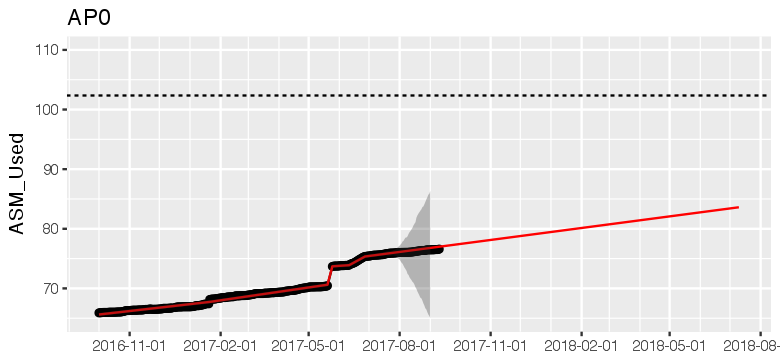

[1] "POSIXct" "POSIXt"

[1] "MAPE for training set: 0.13"
[1] "MAPE for test set: 3.27"
[1] "Value at last timestamp: 76.59"
[1] "Forecast value at last timestamp: 77.01"
[1] "Upper bound on forecast value at last timestamp: 90.33"
[1] "Lower bound on forecast Value at last timestamp: 61.84"


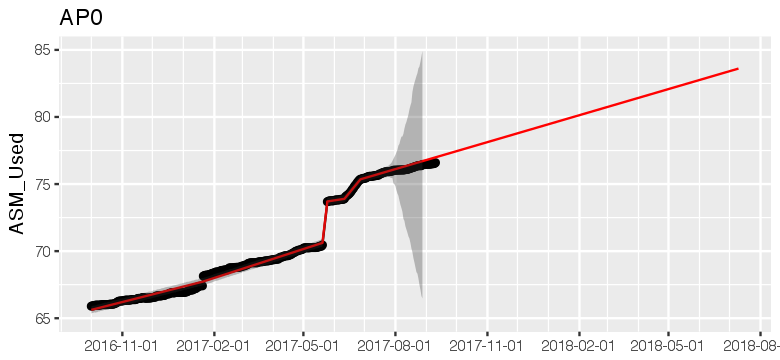

In [168]:
changepoints_from_pra=c("2017-01-21","2017-05-20","2017-05-25","2017-06-11","2017-06-27")
changepoints_from_pra=as.Date(changepoints_from_pra,format="%Y-%m-%d")
m <- prophet(trainingDF,weekly.seasonality=FALSE,yearly.seasonality=FALSE, changepoints=changepoints_from_pra,changepoint.prior.scale=10)
future <- make_future_dataframe(m, periods = n_prediction);
forecast <- predict(m, future);

dFResults=as.data.frame(1:n_data);
forecast$timestamp=as.POSIXct(as.character(forecast$ds), format="%Y-%m-%d",tz="UTC",origin="1970-01-01");
dFResults$timestamp=forecast$timestamp#$timestamp=forecast$ds#c(forecast$ds,future_timestamps)
dFResults$data=c(prophetDF$y,rep(NA,(n_data-length(prophetDF$y))));
dFResults$dataForecast=forecast$yhat;
dFResults$dataForecastConfidenceUB=forecast$yhat_upper;
dFResults$dataForecastConfidenceLB=forecast$yhat_lower;

PlotTheData(dFResults=dFResults, str_pod=str_pod, metric_label=metric_label, TTL=TTL,ylimMin=65,ylimMax=110);
PlotTheData(dFResults=dFResults, str_pod=str_pod, metric_label=metric_label, TTL=TTL,ylimMin=65,ylimMax=85);

max_timestamp=max(prophetDF$ds)
class(max_timestamp)

print(paste('MAPE for training set: ',round(MAPE_training, 2),sep=""))
print(paste('MAPE for test set: ',round(MAPE_test, 2),sep=""))

actual_value=prophetDF[which(prophetDF$ds==max_timestamp),"y"]
actual_value=format(round(actual_value, 2), nsmall = 2)
print(paste('Value at last timestamp:', actual_value))
forecast_value=forecast[which(difftime(forecast$ds,max_timestamp,units="days")==0),"yhat"]
forecast_value=format(round(forecast_value, 2), nsmall = 2)
forecast_ub=forecast[which(difftime(forecast$ds,max_timestamp,units="days")==0),"yhat_upper"]
forecast_ub=format(round(forecast_ub, 2), nsmall = 2)
forecast_lb=forecast[which(difftime(forecast$ds,max_timestamp,units="days")==0),"yhat_lower"]
forecast_lb=format(round(forecast_lb, 2), nsmall = 2)
print(paste('Forecast value at last timestamp:', forecast_value ))
print(paste('Upper bound on forecast value at last timestamp:', forecast_ub))
print(paste('Lower bound on forecast Value at last timestamp:', forecast_lb))

At the last known timestamp, that is on 9/12/2017 the actual value is 76.6Tb while the forecasted value is 77.03Tb (0.43Tb difference) while the upper bound of the forecast is 92.3Tb and lower bound 63.9Tb.

Note that while now the fit is closer, the confidence intervals are quite wide (28.4Tb difference between the lower and upper bounds). This is because Prophet is now able to better represent all the slope changes in the past and because there is a big step on 5/25th which drives the average expected slope change up. Prophet uses this average change in slope to determine what kind of futre changes in slope are expected thus coming up with a wide uncertanity interval.